<a href="https://colab.research.google.com/github/VinayakMaharaj/STA365-Final-Project/blob/main/Proj_test_code_JM_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pymc as pm
import arviz as az
from pymc.math import invlogit as tt_invlogit

df = pd.read_csv('hhs_filter.csv')

Dataset is a log of shot attempts made by the top 15 NBA players in the 2014-15 season who made the most "hot-hand shots".

Our project defines "hot-hand shot" as any shot made by a player after the player has made their last 3 consecutive shots.

In [2]:
print(df.head(n=5))

   Unnamed: 0   GAME_ID LOCATION  SHOT_NUMBER  PERIOD  GAME_HALF GAME_CLOCK  \
0           0  21400907        H            1       1          1       9:49   
1           1  21400907        H            2       1          1       7:26   
2           2  21400907        H            3       1          1       5:34   
3           3  21400907        H            4       1          1       5:00   
4           4  21400907        H            5       1          1       3:33   

   GAME_CLOCK_DECIMAL  SHOT_CLOCK  DRIBBLES  ...  PLAYER_WEIGHT  EXCLUDE  \
0            9.816667        16.3         2  ...       86.18248        1   
1            7.433333        16.6         0  ...       86.18248        1   
2            5.566667        11.0         0  ...       86.18248        1   
3            5.000000        18.5         2  ...       86.18248        1   
4            3.550000         NaN         1  ...       86.18248        1   

  SEASON_SHOTS_TAKEN GAME_SHOTS_TAKEN  SHOT_STREAK  HOT_HAND_SHOT_ST

In [3]:
#need to remove some variables we dont need for the analysis, we helpful when creating the dataset
df2 = df.iloc[:, 1:]

df3 = df2.drop(columns= ["GAME_ID", "GAME_CLOCK","SHOT_STREAK", "GAME_HALF",
                           "player_name", "player_id", "GAME_SHOTS_TAKEN",
                           "SHOT_RESULT", "REFORMATED_DEF_NAME",
                           "CLOSEST_DEFENDER_PLAYER_ID", "SEASON_SHOTS_TAKEN" ])

#remove any rows that have some kind of error we have flagged that cannot be find with generative modeling
df3 = df3[df3.EXCLUDE == 0]

#no longer need exclude and fgm column
clean = df3.drop(columns= ["EXCLUDE"])

# replace 'A' with '0'
clean['LOCATION'].replace('A', 0, inplace=True)
# replace 'A' with '0'
clean['LOCATION'].replace('H', 1, inplace=True)
# when shot clock is NaN, we will replace shot clock with game clock value
clean.loc[df['SHOT_CLOCK'].isnull(),'SHOT_CLOCK'] = df['GAME_CLOCK_DECIMAL']

print(clean.head(n=5))

    LOCATION  SHOT_NUMBER  PERIOD  GAME_CLOCK_DECIMAL  SHOT_CLOCK  DRIBBLES  \
16         0            1       1            6.266667        15.4         0   
17         0            2       1            5.383333        16.2        11   
18         0            3       1            5.233333        18.2         0   
19         0            4       3            9.200000        12.1         0   
20         0            5       3            2.100000        19.4         4   

    SHOT_DIST  PTS_TYPE  DEFENDER_HEIGHT_CM  DEFENDER_WEIGHT_KG  \
16       23.2         3              190.50            90.71840   
17       15.6         2              190.50            86.18248   
18       23.1         3              198.12            99.79024   
19       24.6         3              190.50            90.71840   
20       25.7         3              190.50            90.71840   

    CLOSE_DEF_DIST  FGM  PLAYER_HEIGHT  PLAYER_WEIGHT  HOT_HAND_SHOT_STREAK2  \
16             4.1    0          190.5    

In [4]:
len(clean)
# number of total obs and number of "hot hand shots taken"
print(len(clean), 'and', sum(clean['HOT_HAND_SHOT_STREAK3']))

13579 and 995


In [5]:
np.random.seed(23)
N = 250 #number of samples to make code run faster

# will divide the sample dataset into 2 subdatasets
base = clean[(clean.HOT_HAND_SHOT_STREAK3 ==0)].sample(N, replace=False)
hot = clean[(clean.HOT_HAND_SHOT_STREAK3 ==1) ].sample(N, replace = False)

#combine the 2 sampled datasets so we have equal number of hot shots and non-hot shots
samp = pd.concat([base,hot])

#removes noise and focuses the inference and justifaction fo smaller dataset

print(samp.head(n=5))



       LOCATION  SHOT_NUMBER  PERIOD  GAME_CLOCK_DECIMAL  SHOT_CLOCK  \
4499          1            6       2            2.133333        13.8   
532           1           11       3            7.666667        19.0   
4163          0           16       4            4.433333        10.1   
4126          0           13       3            9.983333         9.5   
11441         1            7       3            8.250000        15.0   

       DRIBBLES  SHOT_DIST  PTS_TYPE  DEFENDER_HEIGHT_CM  DEFENDER_WEIGHT_KG  \
4499          1        5.5         2              195.58          102.058200   
532           6       24.0         3              182.88           79.378600   
4163          0        2.0         2              193.04           88.450440   
4126          2        5.2         2              200.66          104.326160   
11441         9       24.9         3              205.74          102.965384   

       CLOSE_DEF_DIST  FGM  PLAYER_HEIGHT  PLAYER_WEIGHT  \
4499              3.9    1

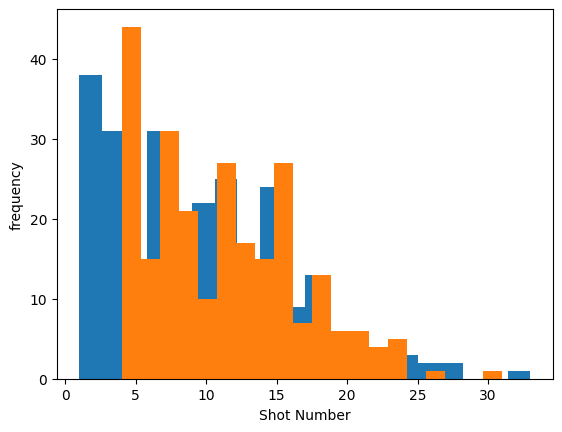

In [6]:
# Exploratory Data Analysis
plt.hist(base['SHOT_NUMBER'],bins=20)
plt.hist(hot['SHOT_NUMBER'],bins=20)
plt.xlabel('Shot Number')
plt.ylabel('frequency')
plt.show()

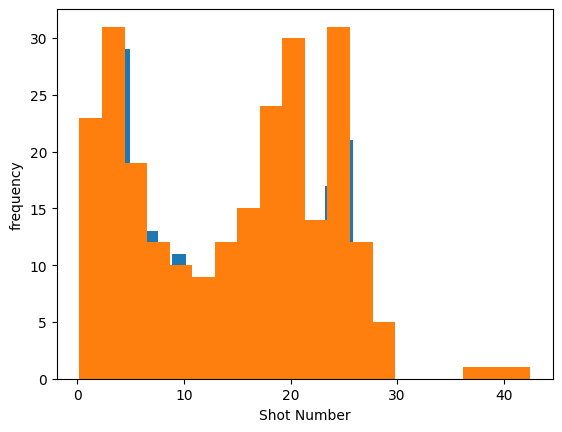

In [7]:
# Exploratory Data Analysis
plt.hist(base['SHOT_DIST'],bins=20)
plt.hist(hot['SHOT_DIST'],bins=20)
plt.xlabel('Shot Number')
plt.ylabel('frequency')
plt.show()

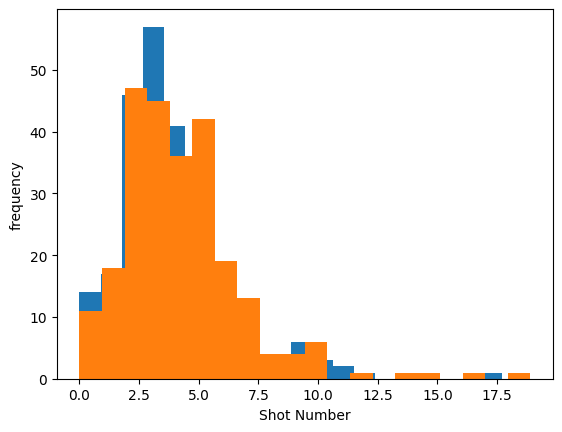

In [8]:
# Exploratory Data Analysis
plt.hist(base['CLOSE_DEF_DIST'],bins=20)
plt.hist(hot['CLOSE_DEF_DIST'],bins=20)
plt.xlabel('Shot Number')
plt.ylabel('frequency')
plt.show()

In [9]:
samp.describe()

LOCATION  SHOT_NUMBER      PERIOD  GAME_CLOCK_DECIMAL  SHOT_CLOCK  \
count  500.000000   500.000000  500.000000          500.000000  500.000000   
mean     0.580000    10.268000    2.502000            4.799333   12.025933   
std      0.494053     5.896925    1.122727            3.249835    6.103627   
min      0.000000     1.000000    1.000000            0.000000    0.000000   
25%      0.000000     5.750000    1.000000            1.979167    7.575000   
50%      1.000000     9.000000    3.000000            4.525000   12.000000   
75%      1.000000    14.000000    3.000000            7.133333   16.825000   
max      1.000000    33.000000    5.000000           11.833333   24.000000   

         DRIBBLES   SHOT_DIST    PTS_TYPE  DEFENDER_HEIGHT_CM  \
count  500.000000  500.000000  500.000000          500.000000   
mean     3.218000   13.819600    2.230000          201.972400   
std      4.689398    8.814977    0.421254            8.884536   
min      0.000000    0.200000    2.000000          175.260000   
25%      0.000000    4.875000    2.000000          195.580000   
50%      2.000000   15.000000    2.000000          203.200000   
75%      4.000000   21.200000    2.000000          208.280000   
max     24.000000   42.500000    3.000000          218.440000   

       DEFENDER_WEIGHT_KG  CLOSE_DEF_DIST         FGM  PLAYER_HEIGHT  \
count          500.000000      500.000000  500.000000     500.000000   
mean           102.434042        4.101600    0.508000     200.126600   
std             11.705415        2.525517    0.500437       8.744983   
min             76.203456        0.000000    0.000000     182.880000   
25%             92.986360        2.575000    0.000000     190.500000   
50%            102.058200        3.500000    1.000000     200.660000   
75%            111.130040        5.225000    1.000000     208.280000   
max            131.541680       18.900000    1.000000     213.360000   

       PLAYER_WEIGHT  HOT_HAND_SHOT_STREAK2  HOT_HAND_SHOT_STREAK3  \
count     500.000000             500.000000             500.000000   
mean      100.436155               0.552000               0.500000   
std        12.046081               0.497787               0.500501   
min        79.378600               0.000000               0.000000   
25%        87.543256               0.000000               0.000000   
50%        99.790240               1.000000               0.500000   
75%       113.398000               1.000000               1.000000   
max       117.933920               1.000000               1.000000   

       GAME_TIME_ELAPSED     num_HHS  num_not_HHS  
count         500.000000  500.000000   500.000000  
mean           25.196667   67.430000   865.404000  
std            13.991615   10.959988    87.173018  
min             0.233333   54.000000   653.000000  
25%            11.979167   58.000000   821.000000  
50%            24.858333   64.000000   888.000000  
75%            35.862500   72.000000   907.000000  
max            50.683333   96.000000   990.000000

In [10]:
#helper function for different model iterations

def predictor_matrix(data: pd.DataFrame, col_names: list, adjust_std=False) -> np.array:
    """
    given a dataframe  and list  containing p column names,
    return a numpy (N x p+1) matrix X with N observations and p
    standardized predictors (first column is the intercept column full of ones)
    if  == True, then use n-1 as divisor for std rather than n when
    standardizing predictors
    """
    predictors = data[col_names].to_numpy()
    normd_predictors = (predictors - np.mean(predictors, axis=0, keepdims=True)) / np.std(predictors, axis=0, keepdims=True, ddof=adjust_std)
    return np.insert(normd_predictors, 0, 1, axis=1)


In [11]:
# model 1
# list of column names you want to keep to use as predictors:
col_names1 = ['LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK_DECIMAL',
            'SHOT_CLOCK', 'DRIBBLES', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
             'DEFENDER_WEIGHT_KG', 'CLOSE_DEF_DIST', 'PLAYER_HEIGHT',
             'PLAYER_WEIGHT', 'HOT_HAND_SHOT_STREAK3']
X1 = predictor_matrix(samp, col_names1)
P1 = X1.shape[1] - 1

#Look into colinearity, and exclude some with high colinearity

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = pd.DataFrame(X1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = ['FGM','LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK_DECIMAL',
            'SHOT_CLOCK', 'DRIBBLES', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
             'DEFENDER_WEIGHT_KG', 'CLOSE_DEF_DIST', 'PLAYER_HEIGHT',
             'PLAYER_WEIGHT', 'HOT_HAND_SHOT_STREAK3']

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

#anything above 5 is high multicolinearity

                  feature       VIF
0                     FGM  1.000000
1                LOCATION  1.016163
2             SHOT_NUMBER  4.081128
3                  PERIOD  3.760839
4      GAME_CLOCK_DECIMAL  1.431186
5              SHOT_CLOCK  1.242037
6                DRIBBLES  1.472780
7               SHOT_DIST  1.475804
8      DEFENDER_HEIGHT_CM  3.416545
9      DEFENDER_WEIGHT_KG  3.484530
10         CLOSE_DEF_DIST  1.258158
11          PLAYER_HEIGHT  7.704312
12          PLAYER_WEIGHT  6.803212
13  HOT_HAND_SHOT_STREAK3  1.129418


In [13]:
# model 2, removed some predictors with high multicolinearity or were variables we felt were not nessesary

col_names2 = ['LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
              'CLOSE_DEF_DIST','PLAYER_HEIGHT', 'HOT_HAND_SHOT_STREAK3']
X2 = predictor_matrix(samp, col_names2)
P2 = X2.shape[1] - 1
P2


7

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = pd.DataFrame(X2)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = ['FGM','LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
               'CLOSE_DEF_DIST', 'PLAYER_HEIGHT', 'HOT_HAND_SHOT_STREAK3']

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

#anything above 5 is high multicolinearity, notice how all predictors look to have little multi-colinearity

                 feature       VIF
0                    FGM  1.000000
1               LOCATION  1.010838
2             SHOT_CLOCK  1.102264
3              SHOT_DIST  1.401935
4     DEFENDER_HEIGHT_CM  1.175083
5         CLOSE_DEF_DIST  1.238170
6          PLAYER_HEIGHT  1.220085
7  HOT_HAND_SHOT_STREAK3  1.027967


In [15]:
y2 = np.zeros((2*N,1))
y2[:,0] = samp['FGM']

In [16]:
import pymc as pm; import numpy as np
#model 1, Basic multivariate bayesian regression model
#redefine col names just for naming ease
col_names = ['Intercept', 'LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
              'CLOSE_DEF_DIST','PLAYER_HEIGHT', 'HOT_HAND_SHOT_STREAK3']

with pm.Model(coords={"cluster": col_names}) as MLR:
    betas = pm.MvNormal('betas', mu= np.zeros((P2+1,)), cov=np.eye(P2+1), shape=(P2+1,), dims = 'cluster')
    y = pm.Bernoulli('y', logit_p = pm.math.dot(X2, betas), observed = y2)
with MLR:
    idata = pm.sample(random_seed=1999)

# do more analysis / visualizations

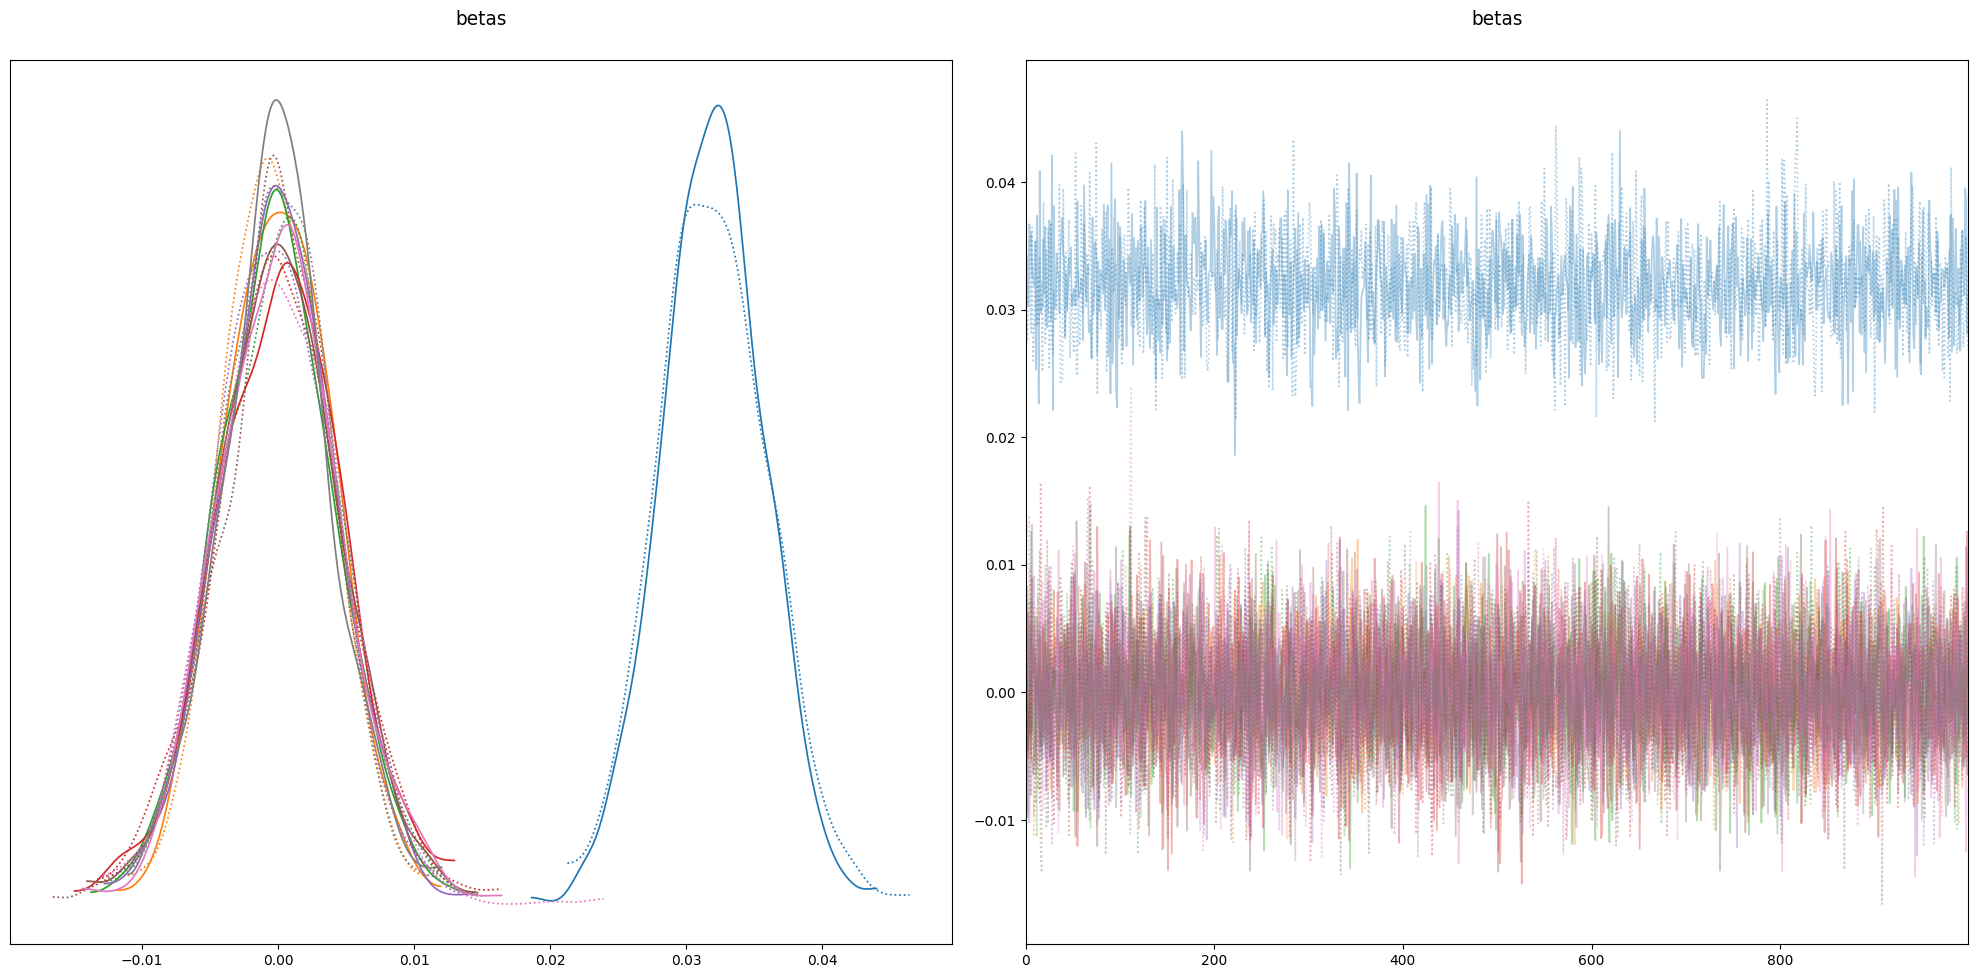

HMC Split-Rhats {'betas': array([1.0033579 , 1.00030929, 1.00242101, 0.99943513, 1.00137323,
       1.00003496, 1.00036752, 0.99937812])} | 

In [23]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Update matplotlib settings for larger fonts
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Increase figure size for better layout
# The 'figsize' parameter determines the size of the entire figure, not individual subplots.
az.plot_trace(idata, compact=True, combined=False, figsize=(20, 10))
plt.tight_layout()  # Adjust layout to fit the increased font sizes and figure dimensions
plt.show()

# Print the R-hat statistics as before
rhat_values = az.rhat(idata)
print("HMC Split-Rhats", {k: np.round(v.values, P2+1) for k, v in rhat_values.items()}, end=' | ')


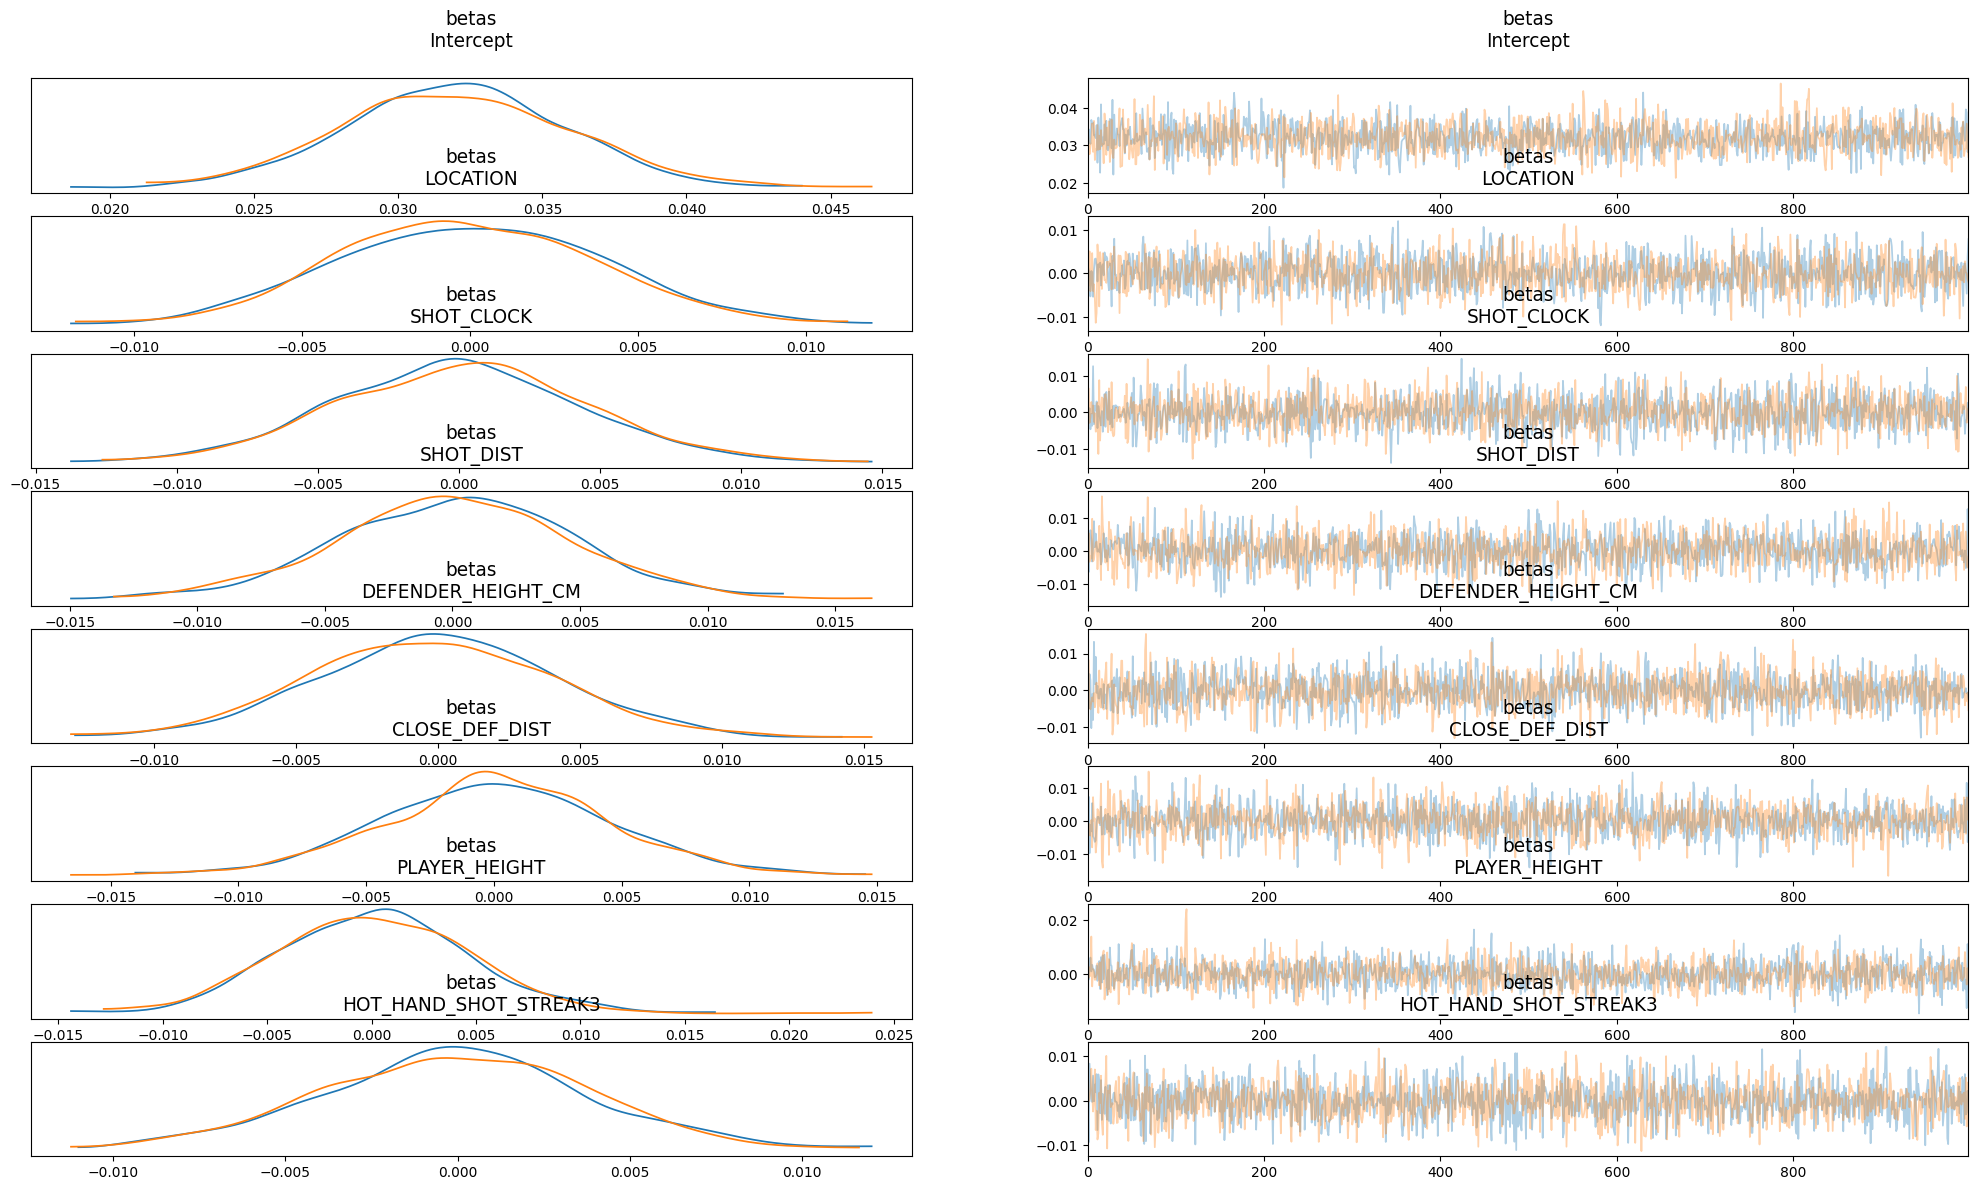

HMC Split-Rhats {'betas': array([1.0033579 , 1.00030929, 1.00242101, 0.99943513, 1.00137323,
       1.00003496, 1.00036752, 0.99937812])} | 

In [25]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Customizing plot parameters for better readability
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Increase the figure size
# Note: compact=False ensures that each variable has two subplots, one for the trace and one for the density
# If the resulting plot still appears squished, consider making the figure size even larger,
# or reducing the number of variables plotted in a single call to plot_trace
az.plot_trace(idata, compact=False, combined=False, figsize=(25, P2*2))  # P2 is the number of parameters

# The layout will be adjusted automatically since we are not using 'ax' anymore
plt.show()

# Print the R-hat statistics
rhat_values = az.rhat(idata)
print("HMC Split-Rhats", {k: np.round(v.values, P2+1) for k, v in rhat_values.items()}, end=' | ')


In [20]:

import pymc as pm; import numpy as np
from pymc.math import invlogit as tt_invlogit
#model 2, multivariate bayesian heirarchial regression using a horshoe prior and LKJ factor
with pm.Model(coords={"cluster": col_names}) as MLR:
    #LKJ cov
    packed_L = pm.LKJCholeskyCov("packed_L", n= P2+1, eta=2.0, sd_dist=pm.HalfCauchy.dist(beta=10, shape=P2+1), compute_corr=False)
    L = pm.expand_packed_triangular(P2+1, packed_L);
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    #Horsehoe prior to help distinguish useful predictors
    tau_0 = 1;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape= 1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=1);
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P2+1))
    betas = pm.MvNormal('betas', mu= np.zeros((P2+1,)), cov= Sigma, shape=(P2+1,), dims = 'cluster')

    y = pm.Bernoulli('y', logit_p = pm.math.dot(X2, betas*weights), observed = y2)
with MLR:
    MH = pm.Metropolis([betas], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH,random_seed=1999)

    #for proj we can make note on how long it takes computationally to use chol
    #problem in mixing?
    #invalid value could be near 0 value in log

ValueError: Not enough samples to build a trace.

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (118), generating only 20 plots
  warnings.warn(


HMC Split-Rhats {'weights': array([2.65063883, 1.10834049, 1.0528576 , 1.06753591, 1.07394668,
       1.03228699, 1.07382306, 1.06396841]), 'betas': array([2.78940334, 1.08362155, 1.17320821, 1.026018  , 1.10622362,
       1.19656092, 1.14278172, 1.07943032]), 'packed_L': array([1.15558387, 1.01970725, 1.02405053, 1.01442191, 1.01922553,
       1.02406955, 1.01383725, 1.01628807, 1.01487949, 1.02452627,
       1.02499713, 1.01569908, 1.0201291 , 1.01415872, 1.02944273,
       1.00193078, 1.00490277, 1.01001667, 1.01211499, 1.00505936,
       1.00839741, 1.03534404, 1.02722192, 1.02163077, 1.0236175 ,
       1.02543198, 1.02217999, 1.04042644, 1.00093493, 1.00407786,
       1.00247404, 1.0027799 , 1.00553401, 1.00105198, 1.00500779,
       1.01321945]), 'tau': array([1.02848914]), 'lambdas': array([1.039741]), 'Sigma': array([[1.15558387, 1.10294434, 1.08443666, 1.10041207, 1.08602232,
        1.04057768, 1.09513331, 1.05134479],
       [1.10294434, 1.0247274 , 1.03506051, 1.03316422, 1

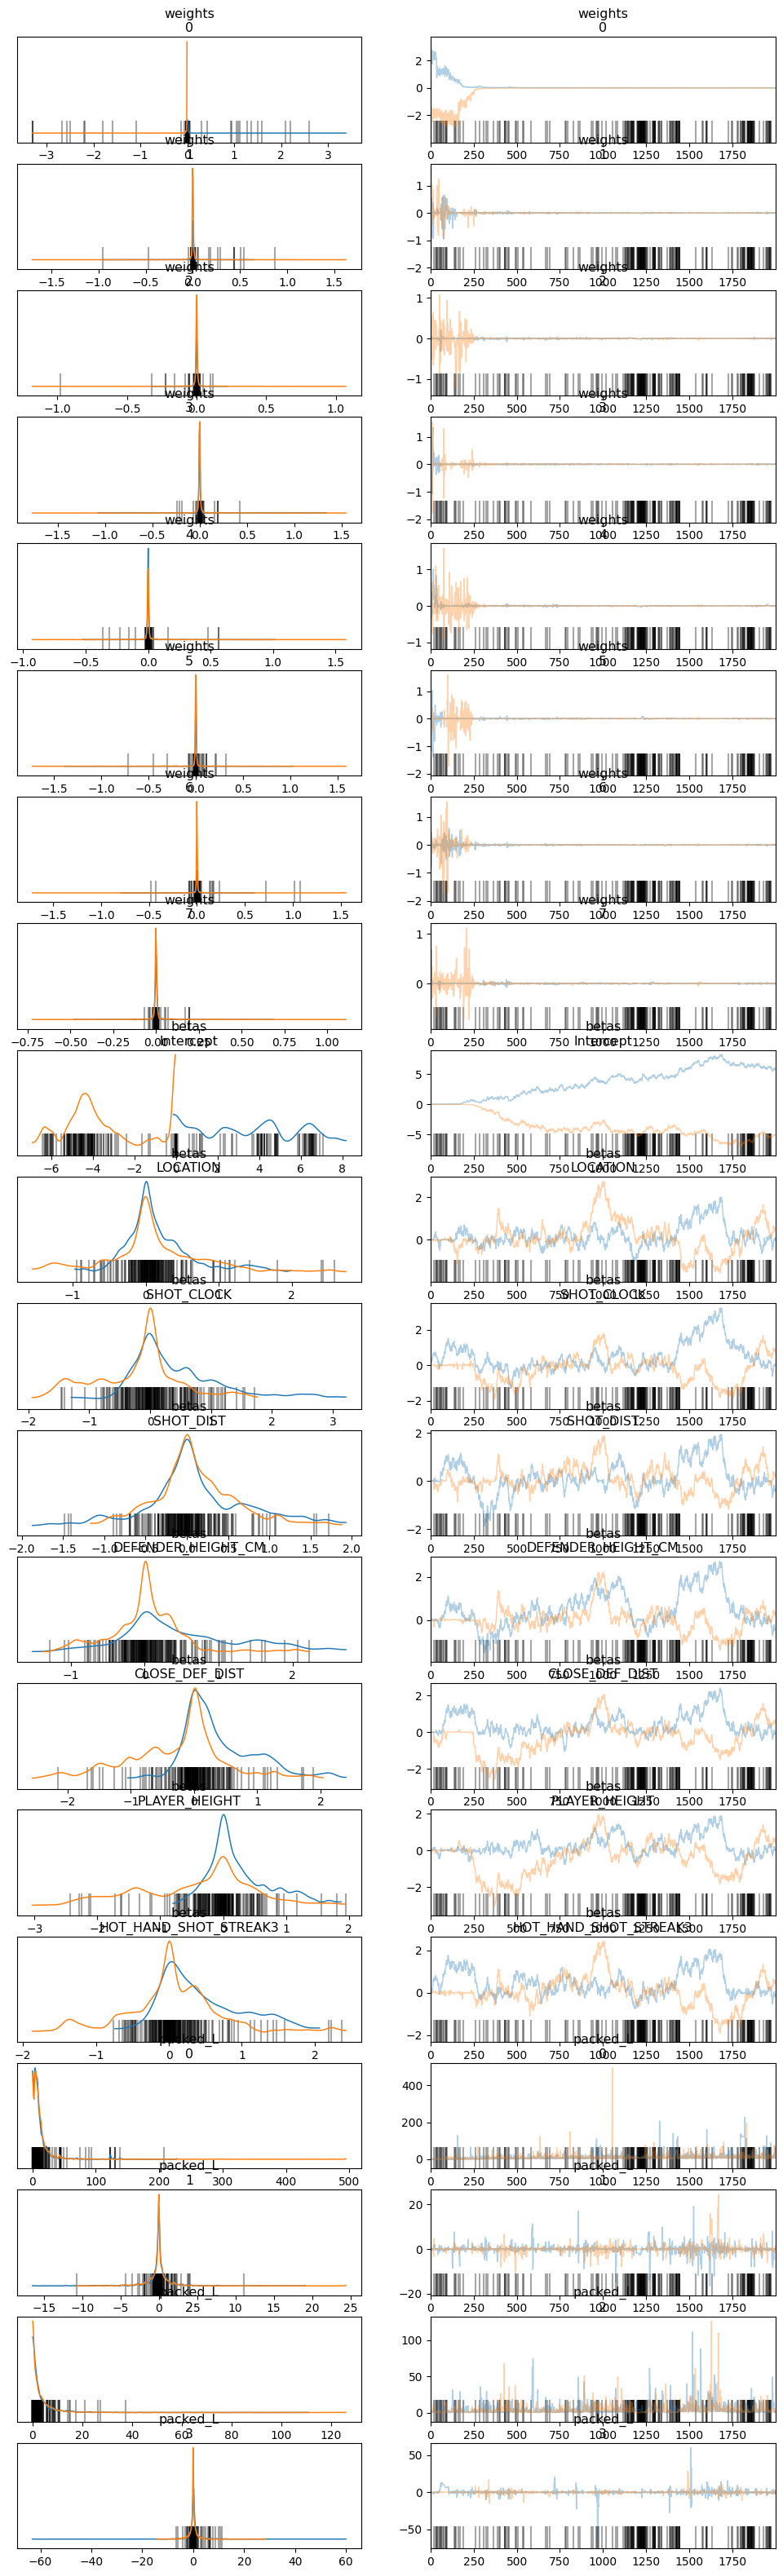

In [ ]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata_MH,compact=False, combined = False);
print("HMC Split-Rhats", {k: np.round(v.values,P2+1) for k,v in az.rhat(idata_MH).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.

In [ ]:
import pymc as pm; import numpy as np
from pymc.math import invlogit as tt_invlogit

#model 3, bayesian multivariate regression model with horseshoe prior
with pm.Model(coords={"cluster": col_names}) as MLR:

    #Horsehoe prior to help distinguish useful predictors
    tau_0 = 1;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=1);
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P2+1))
    betas = pm.MvNormal('betas', mu= np.zeros((P2+1,)), cov= np.eye(P2+1), shape=(P2+1,), dims = 'cluster')

    y = pm.Bernoulli('y', logit_p = pm.math.dot(X2, betas*weights), observed = y2)
with MLR:
    idata = pm.sample(random_seed=1999)

    #misspecified horshoe bc not shrinking to 0
    #regularized horseshoe, seeing something interestin with bi-modal, report on

HMC Split-Rhats {'weights': array([1.82985576, 1.00233606, 1.00391283, 1.00091038, 1.001037  ,
       1.0004979 , 1.00186548, 1.00151218]), 'betas': array([1.82888764, 1.00318241, 1.00227055, 1.00195173, 1.00144341,
       0.99980027, 0.9997767 , 1.00084904]), 'tau': array([1.00004101]), 'lambdas': array([1.00098001])} | 

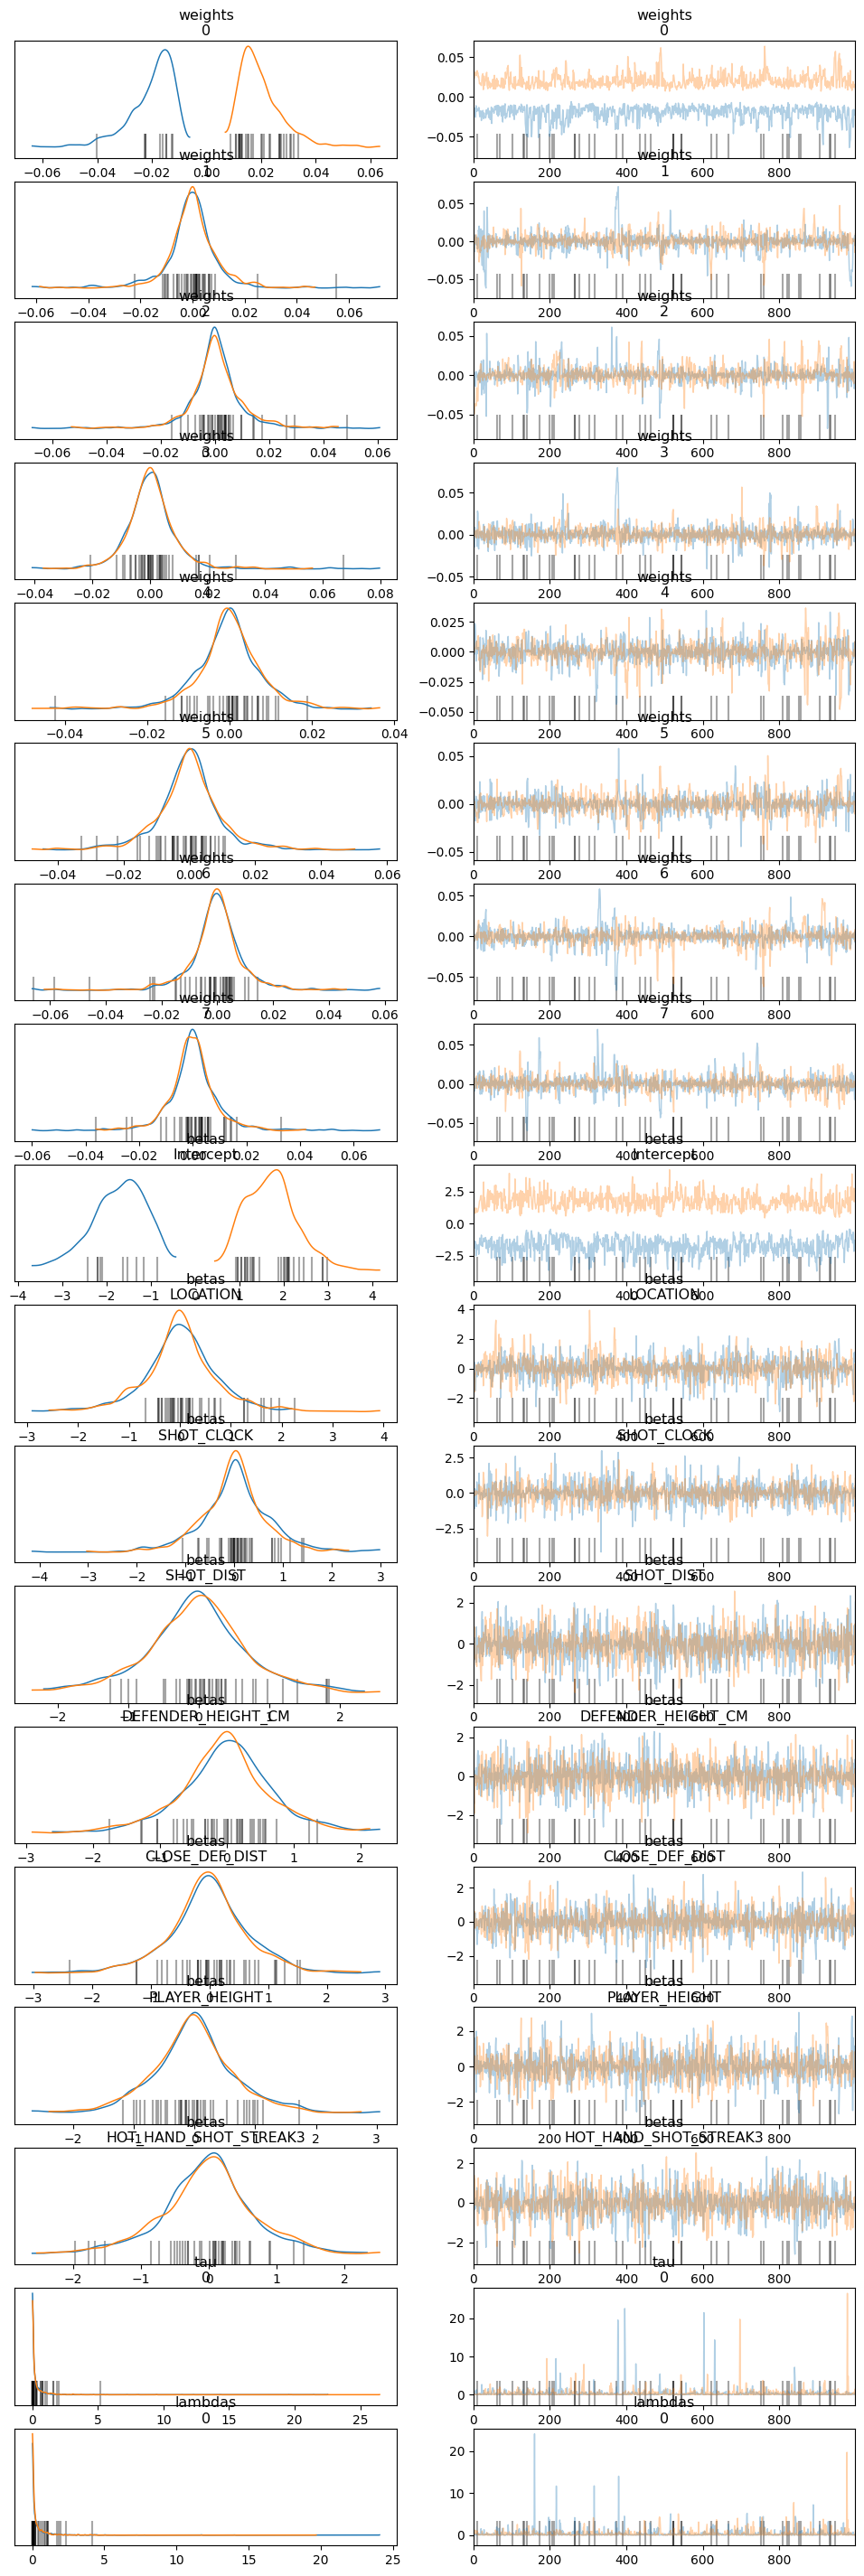

In [ ]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata,compact=False, combined = False);
print("HMC Split-Rhats", {k: np.round(v.values,P2+1) for k,v in az.rhat(idata).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.


                               mean     sd  hdi_3%  hdi_97%  mcse_mean  \
weights[0]                   -0.000  0.022  -0.034    0.037      0.014   
weights[1]                   -0.000  0.011  -0.022    0.018      0.000   
weights[2]                    0.000  0.011  -0.017    0.023      0.000   
weights[3]                    0.001  0.010  -0.016    0.017      0.000   
weights[4]                   -0.001  0.009  -0.016    0.018      0.000   
weights[5]                   -0.000  0.010  -0.019    0.019      0.000   
weights[6]                   -0.000  0.010  -0.019    0.019      0.000   
weights[7]                    0.000  0.010  -0.020    0.019      0.000   
betas[Intercept]             -0.003  1.836  -2.716    2.825      1.233   
betas[LOCATION]               0.009  0.718  -1.275    1.570      0.022   
betas[SHOT_CLOCK]             0.008  0.697  -1.423    1.303      0.017   
betas[SHOT_DIST]             -0.030  0.713  -1.446    1.416      0.017   
betas[DEFENDER_HEIGHT_CM]    -0.011  0

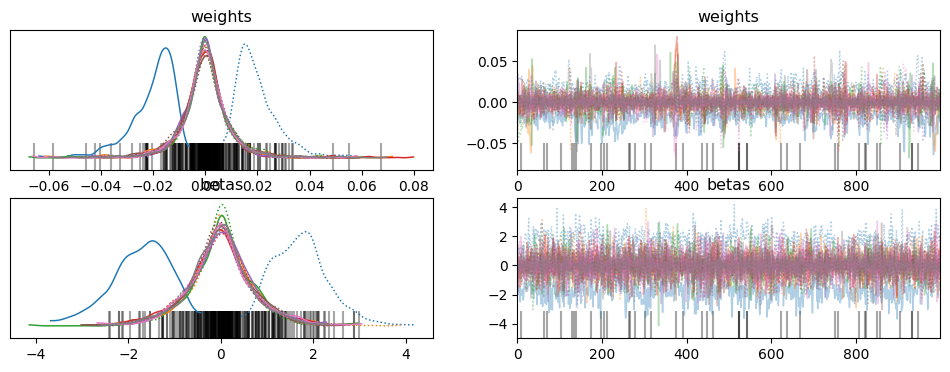

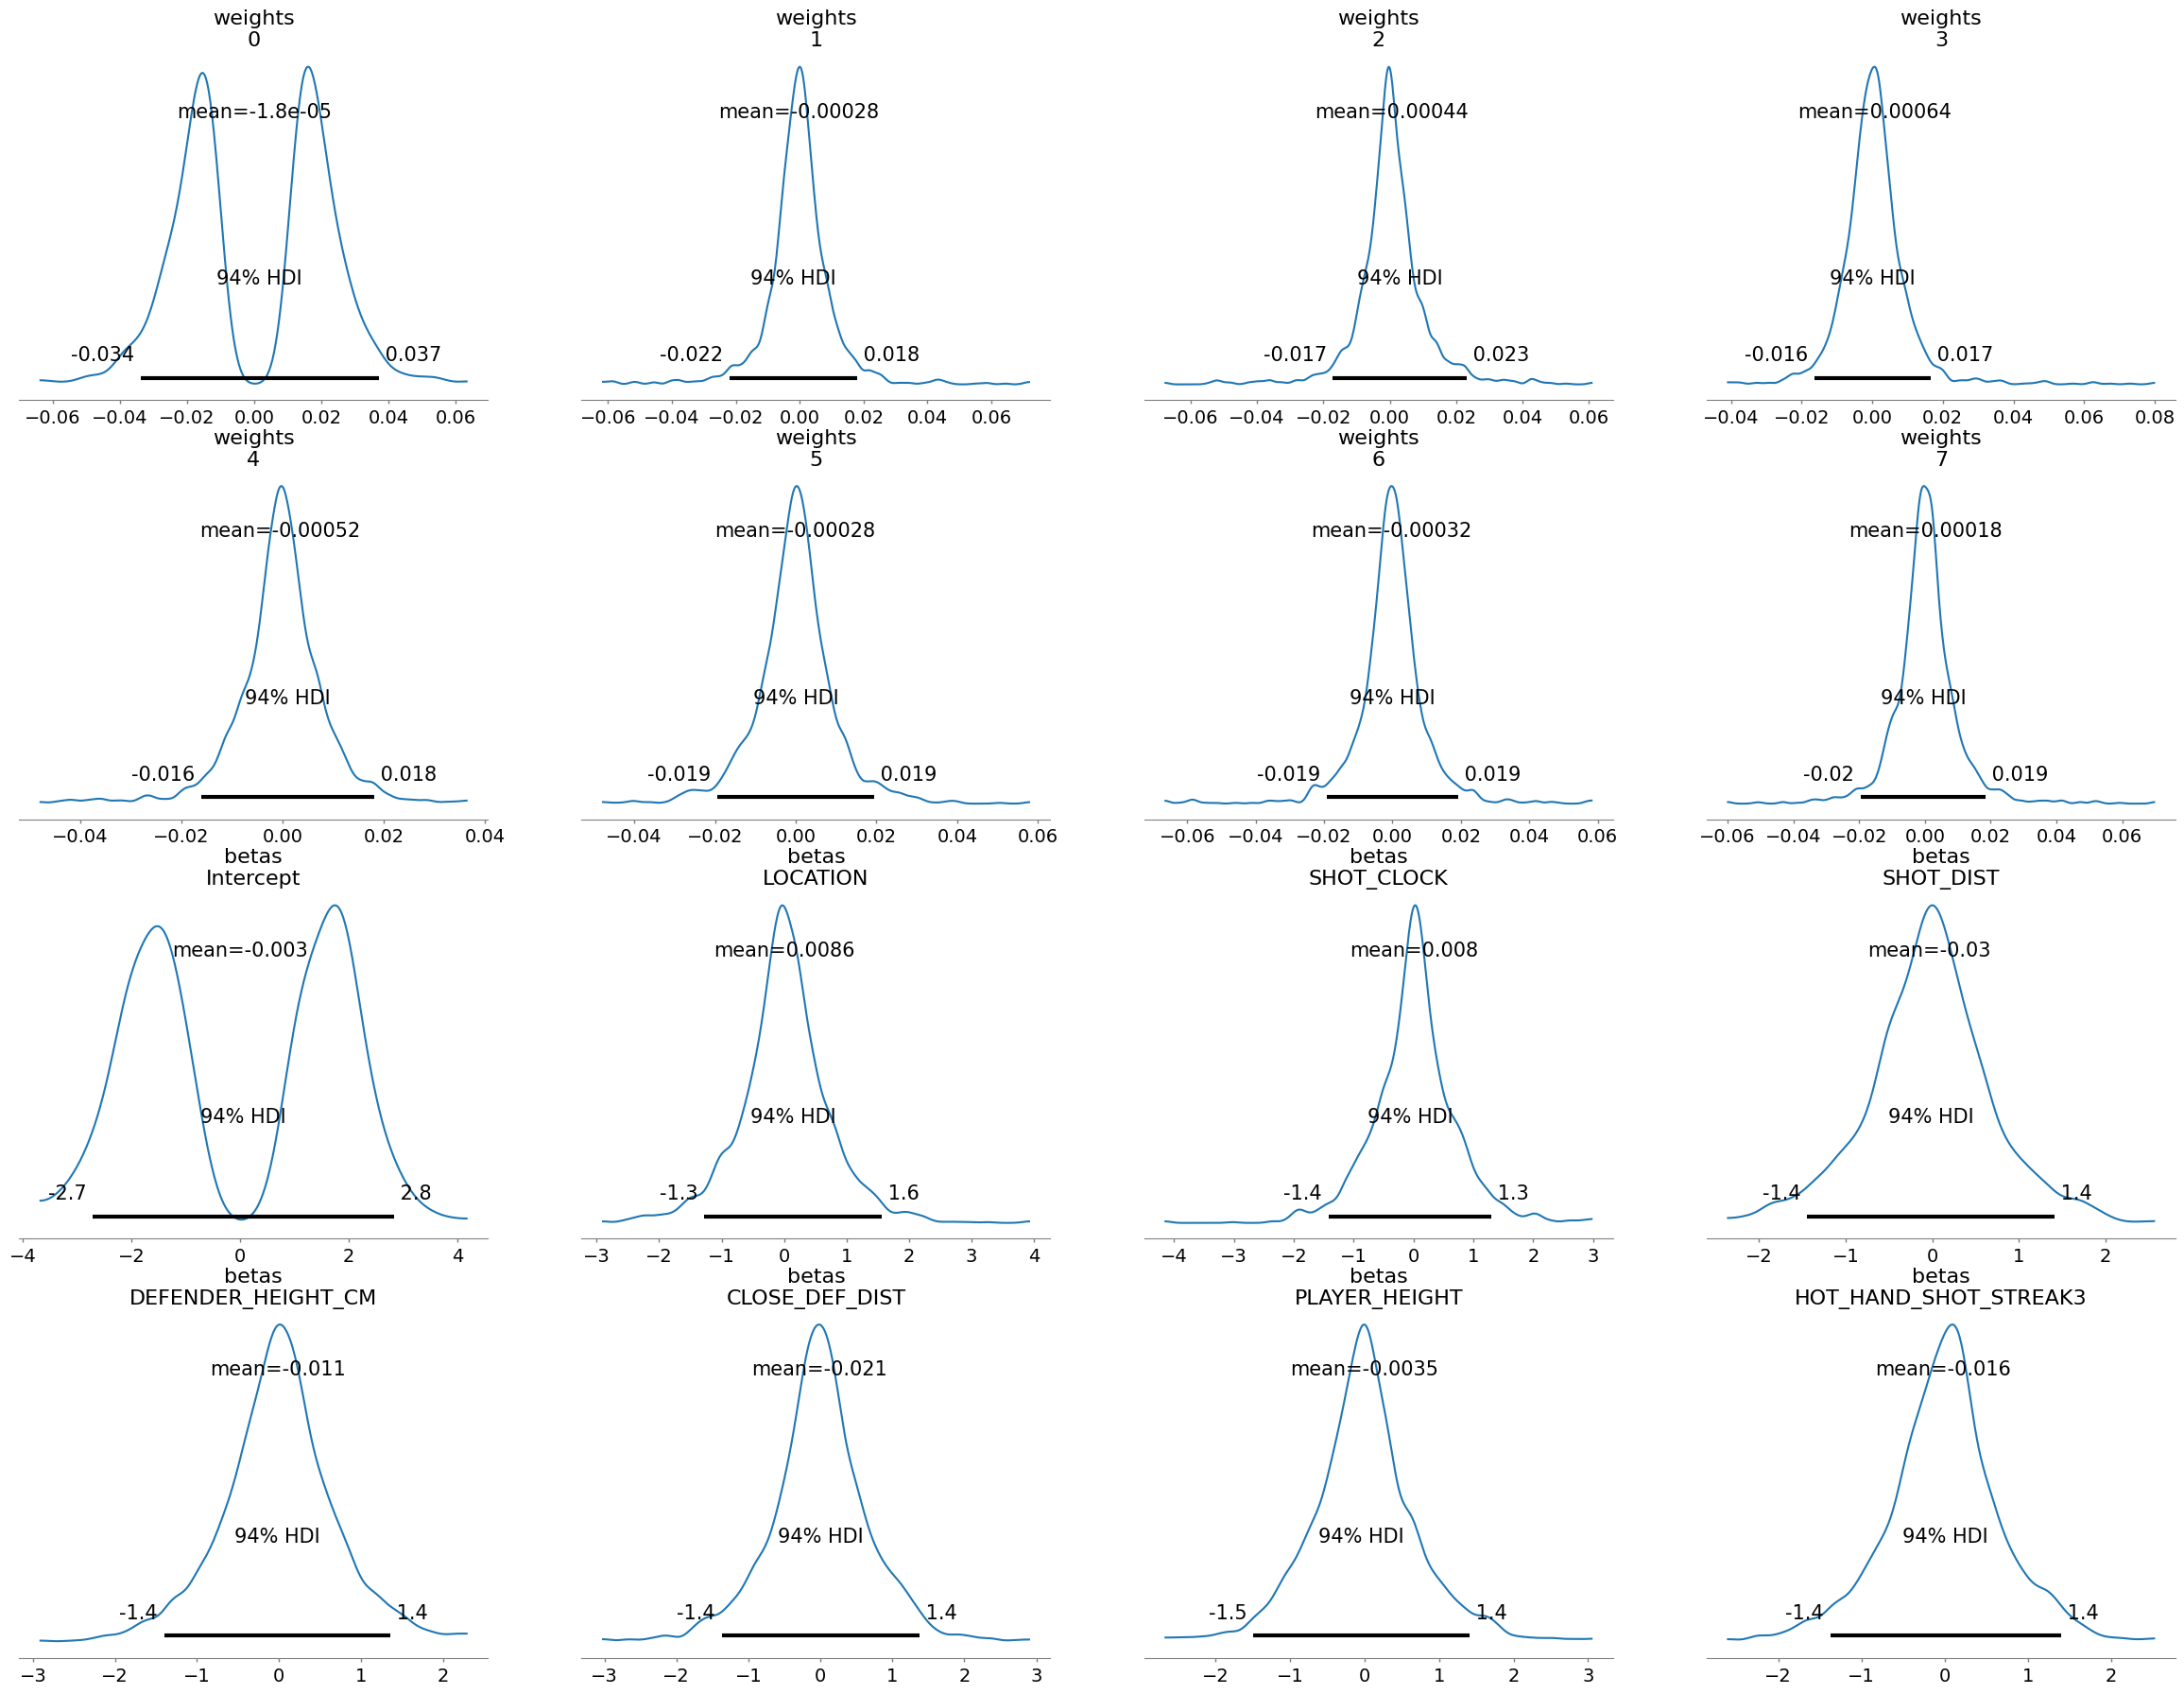

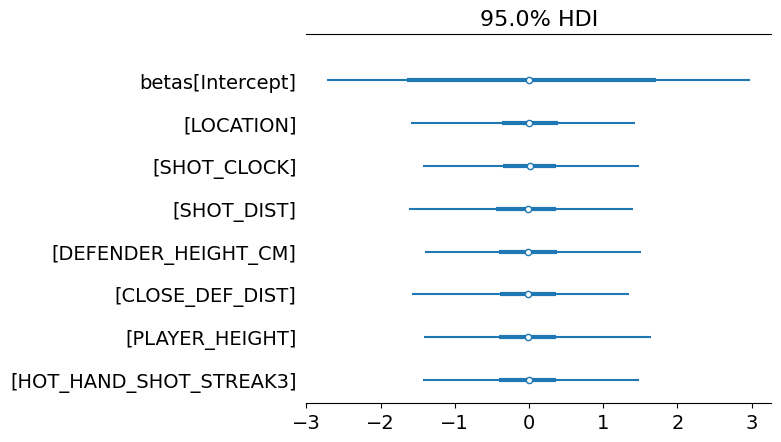

/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


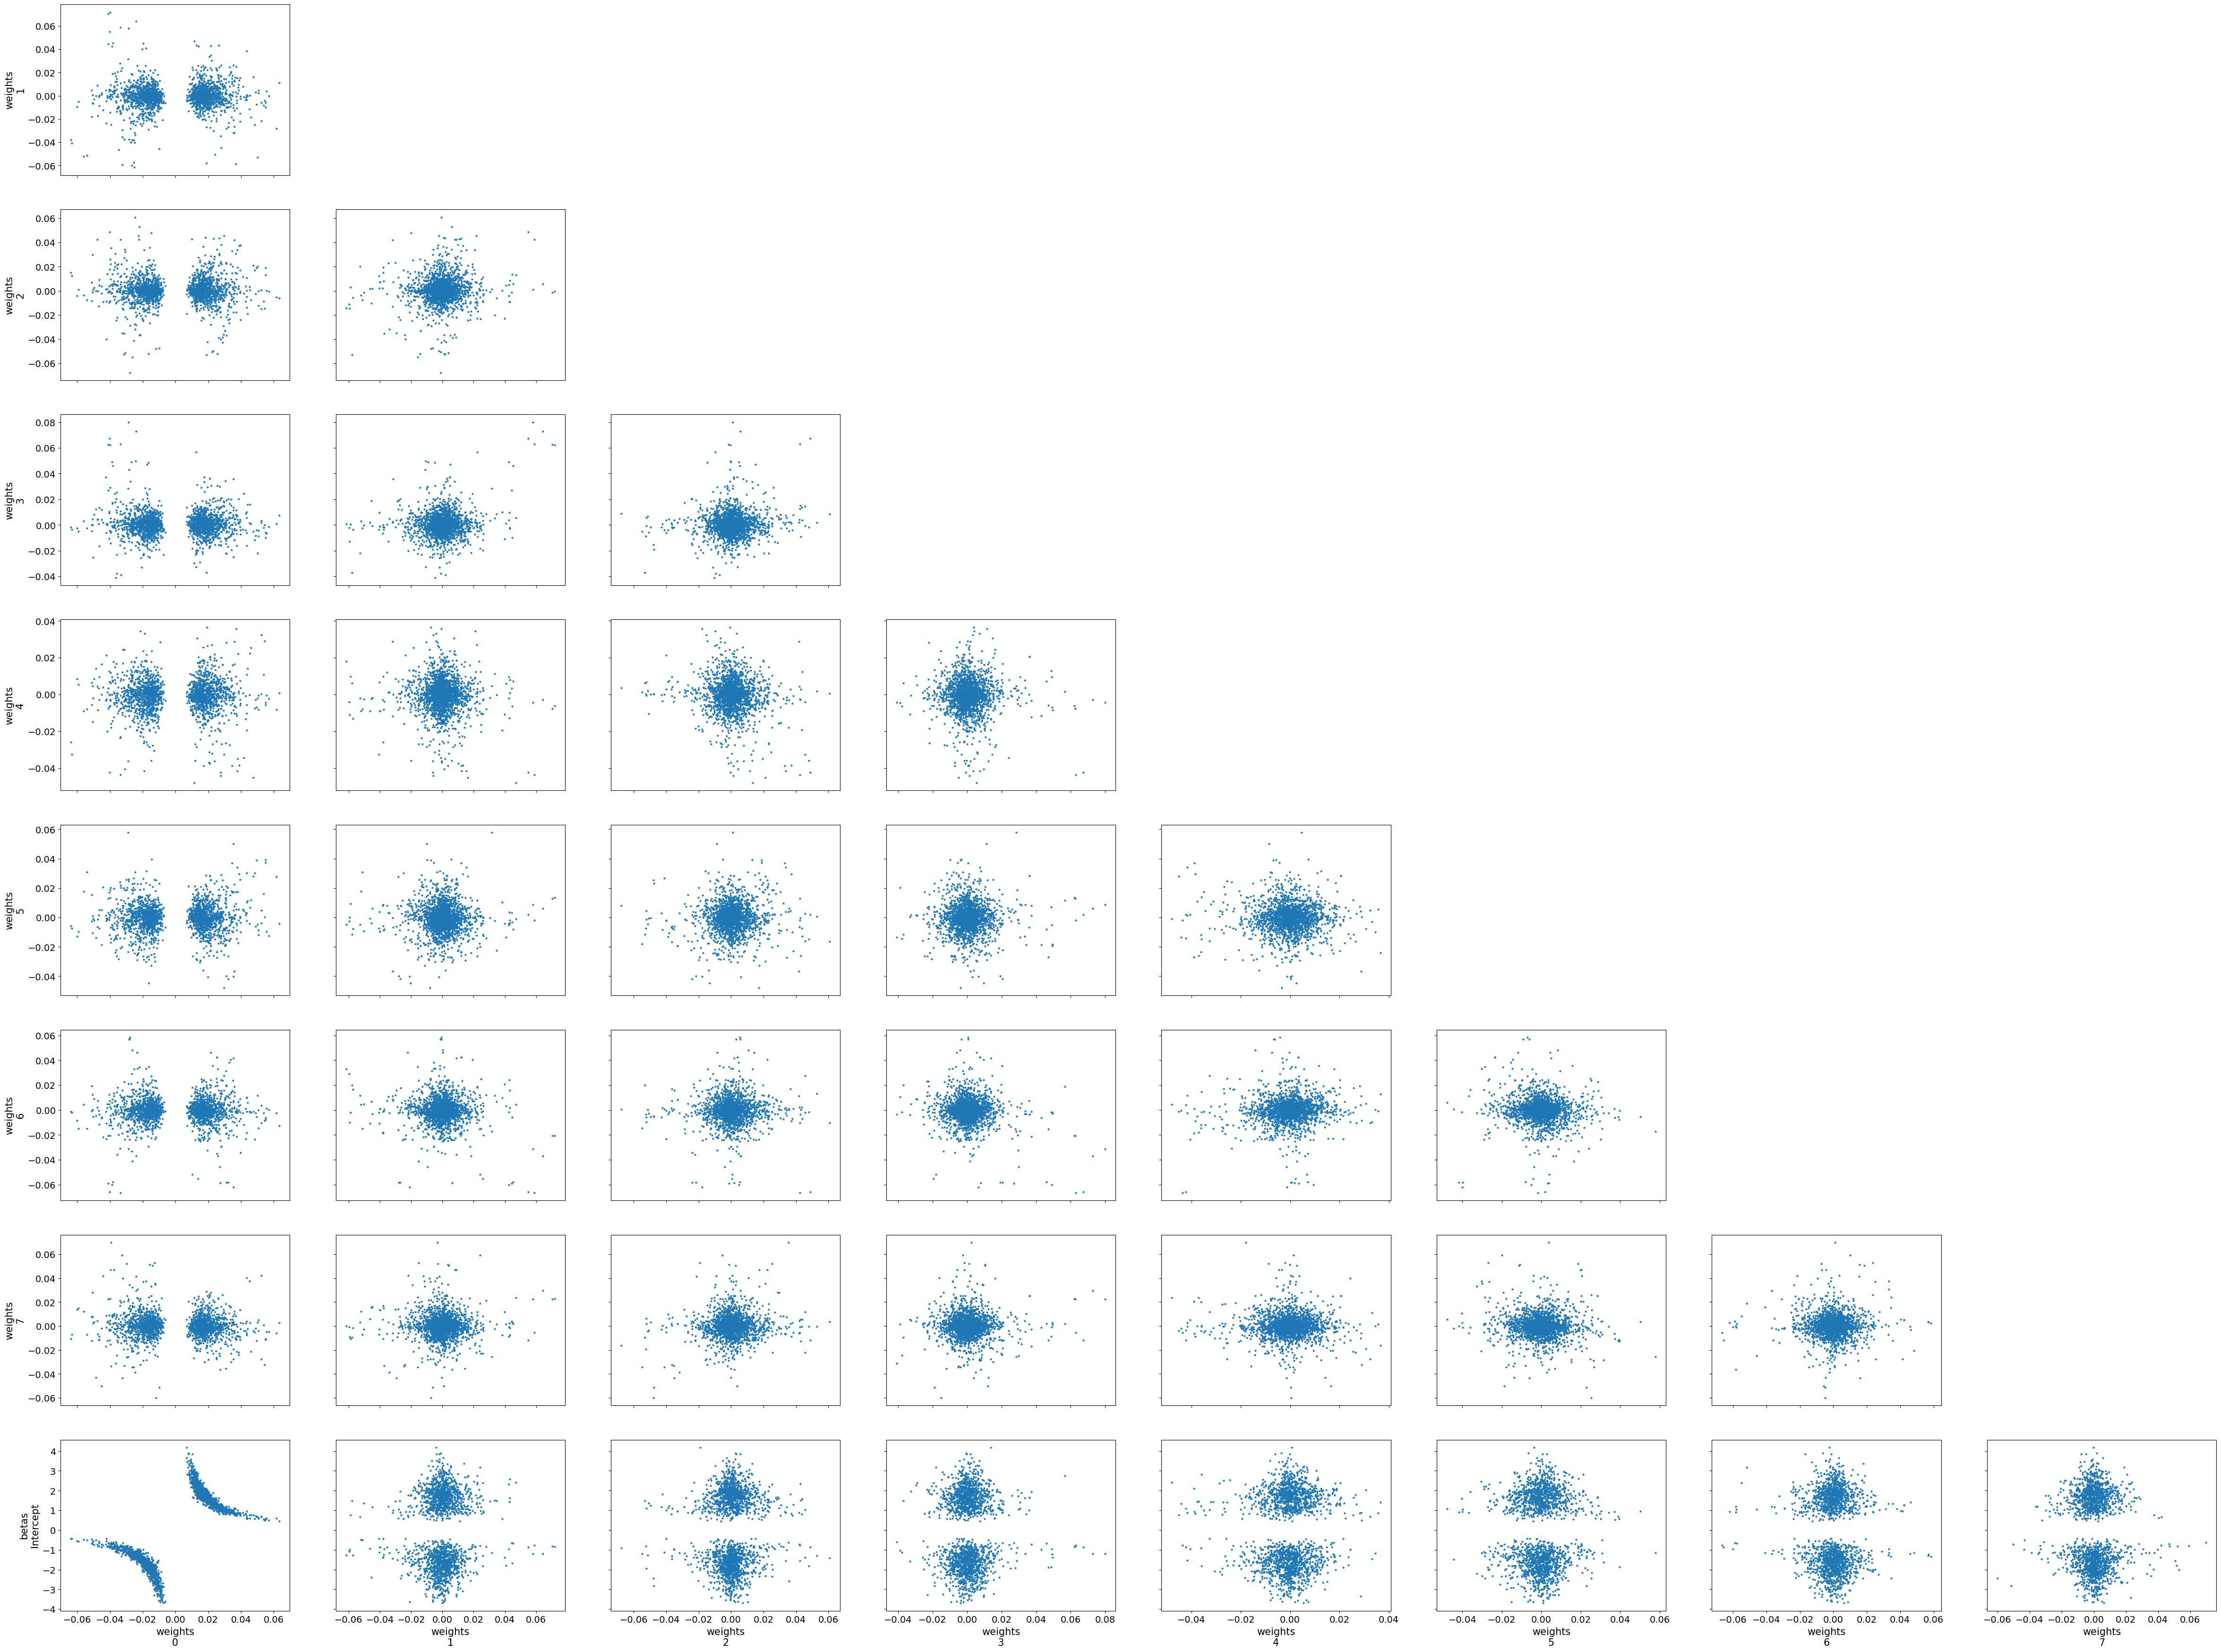

In [ ]:

# Analysis and Visualization
# Summary statistics
summary = az.summary(idata, var_names=['weights', 'betas'])
print(summary)

# Trace plot
az.plot_trace(idata, var_names=['weights', 'betas'])
plt.show()

# Posterior plot
az.plot_posterior(idata, var_names=['weights', 'betas'])
plt.show()

# Forest plot for betas
az.plot_forest(idata, var_names=['betas'], combined=True, hdi_prob=0.95)
plt.show()

# Pair plot for exploring relationships between parameters
az.plot_pair(idata, var_names=['weights', 'betas'])
plt.show()


In [26]:
#model 4, multivariate bayesian regression with standard normal prior on all predictors other than hot-hand, hot hand has a spike slab with standard normal prior
P2 = X2.shape[1]

col_names = ['Intercept', 'LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
              'CLOSE_DEF_DIST','PLAYER_HEIGHT']
with pm.Model(coords={"cluster": col_names}) as model:
    # Spike-Slab components for the HOT_HAND_SHOT_STREAK3 coefficient
    inclusion_prob = pm.Beta('inclusion_prob', alpha=1, beta=1)
    slab = pm.Normal('slab', mu=0, sigma=1)

    # Binary variable to choose between spike (effect = 0) and slab
    include_effect = pm.Bernoulli('include_effect', p=inclusion_prob)

    # Coefficient for HOT_HAND_SHOT_STREAK3
    # beta_hot_hand = pm.math.switch(include_effect, slab, 0)
    beta_hot_hand = pm.Deterministic("beta_hot_hand", include_effect*slab)

    # Coefficients for other predictors
    #betas_other = pm.Normal('betas_other', mu=0, sigma=1, shape=(P2-1,), dims = 'cluster')
    betas_other = pm.MvNormal('betas_other', mu= np.zeros((P2,)), cov= np.eye(P2), shape=(P2,), dims = 'cluster')

    # Combine all coefficients, assuming HOT_HAND_SHOT_STREAK3 is the last predictor in X2
    # Adjust the concatenation logic if HOT_HAND_SHOT_STREAK3 is in a different position
    betas = pm.math.concatenate([betas_other, [beta_hot_hand]])

    # Calculate the probability of a shot being made
    p_shot_made = pm.math.sigmoid(pm.math.dot(X2, betas))

    # Likelihood of observing the data
    y = pm.Bernoulli('y', p=p_shot_made, observed=y2.flatten())
with MLR:
    idata = pm.sample(random_seed=1999)


/usr/local/lib/python3.10/dist-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (118), generating only 20 plots
  warnings.warn(
<ipython-input-30-436738726da7>:21: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.75, wspace=0.75)


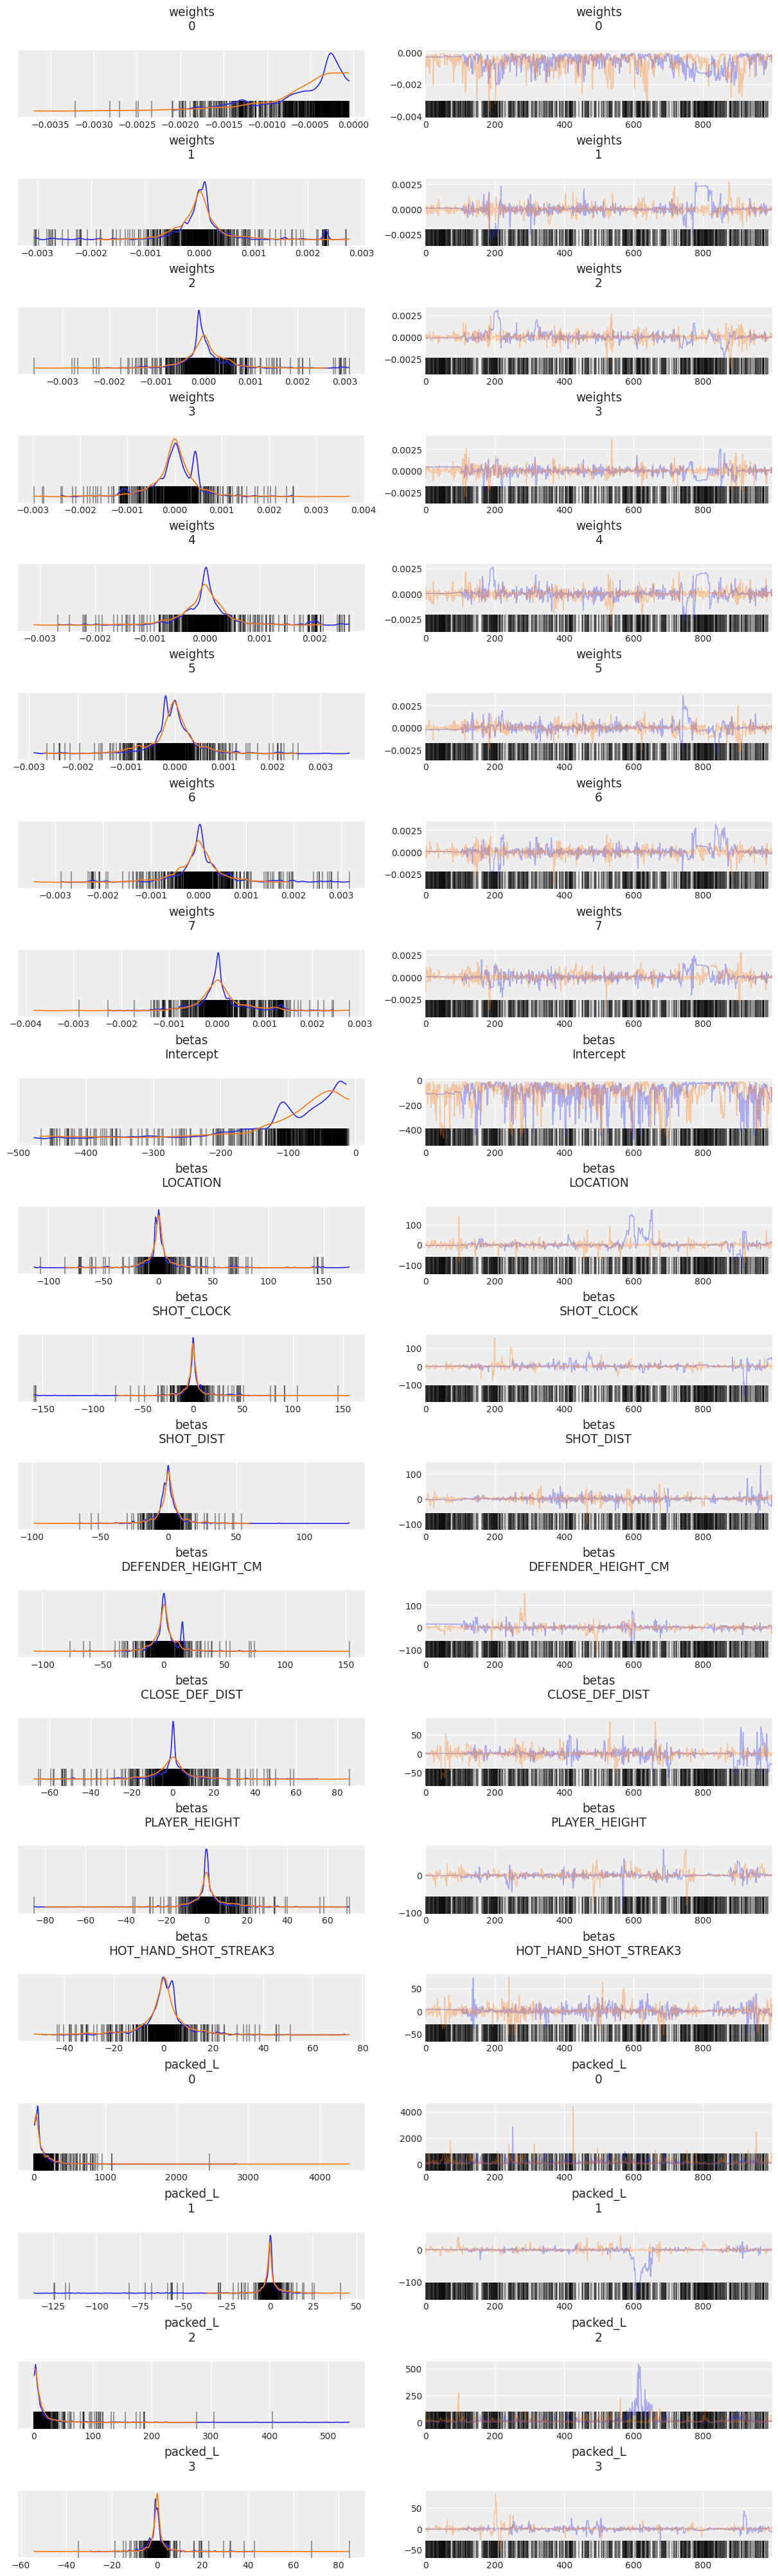

HMC Split-Rhats {'weights': array([1.0112214, 1.0042575, 1.0103564, 1.0084442, 1.0123939, 1.0020876,
       1.0144481, 1.011127 ]), 'betas': array([1.0044915, 1.0103016, 1.009315 , 1.0029919, 1.014168 , 1.0311094,
       1.0117074, 1.0016221]), 'packed_L': array([1.0137024, 1.010438 , 1.0225062, 1.0076436, 1.0115135, 1.003673 ,
       1.0074092, 1.0038258, 1.0187837, 1.0030159, 1.0091611, 1.0099431,
       1.0120116, 1.0114205, 1.0183553, 1.0345526, 1.0360061, 1.0302127,
       1.04399  , 1.0351357, 1.0566537, 1.0138561, 1.0142082, 1.01855  ,
       1.0063235, 1.0175075, 1.0050531, 1.0176578, 1.0161502, 1.0232164,
       1.0139792, 1.0121043, 1.0089689, 1.0065891, 1.0112204, 1.0184874]), 'tau': array([1.0126194]), 'lambdas': array([1.0108337]), 'Sigma': array([[1.0128609, 1.0113614, 1.0042707, 1.002951 , 1.0081892, 1.0277727,
        1.0084653, 1.0104072],
       [1.0113614, 1.0221584, 1.0209144, 1.0187479, 1.0053302, 1.0459343,
        1.0073484, 1.0348674],
       [1.0042707, 1.02091

In [30]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Customize plot parameters for better readability
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    # Adjust the figure size here if needed (width, height)
    'figure.figsize': (15, P2 * 2)  # P2 is the number of parameters to plot
})

# Plot the trace for all variables. We let ArviZ handle the subplots internally.
az.plot_trace(idata, compact=False, combined=False)

# Adjust the layout to prevent overlapping labels and titles.
# This will add space between subplots.
plt.subplots_adjust(hspace=0.75, wspace=0.75)

# Show the plot
plt.show()

# Print R-hat statistics
rhat_stats = az.rhat(idata)
rhat_stats_rounded = {k: np.round(v.values, P2+1) for k, v in rhat_stats.items()}
print("HMC Split-Rhats", rhat_stats_rounded, end=' | ')


# None of the split R hats values is greater than 1.05 and there is no sign of divergence.


In [ ]:
#model 5

P2 = X2.shape[1]

with pm.Model() as model:
    # Spike-Slab components for the HOT_HAND_SHOT_STREAK3 coefficient
    inclusion_prob = pm.Beta('inclusion_prob', alpha=1, beta=1)
    slab = pm.Normal('slab', mu=0, sigma=1)

    # Binary variable to choose between spike (effect = 0) and slab
    include_effect = pm.Bernoulli('include_effect', p=inclusion_prob)

    # Coefficient for HOT_HAND_SHOT_STREAK3
    # beta_hot_hand = pm.math.switch(include_effect, slab, 0)
    beta_hot_hand = pm.Deterministic("beta_hot_hand", include_effect*slab)


    #Horsehoe prior to help distinguish useful predictors
    tau_0 = 0.75;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=1);
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=P2-1)

    # Coefficients for other predictors, using horsehoe
    #betas_other = pm.Normal('betas_other', mu=0, sigma=1, shape=(P2-1,))
    betas_other = pm.MvNormal('betas_other', mu= np.zeros((P2-1,)), cov= np.eye(P2-1), shape=(P2-1,))

    # Combine all coefficients, assuming HOT_HAND_SHOT_STREAK3 is the last predictor in X2
    # Adjust the concatenation logic if HOT_HAND_SHOT_STREAK3 is in a different position
    betas = pm.math.concatenate([betas_other*weights, [beta_hot_hand]])

    # Calculate the probability of a shot being made
    p_shot_made = pm.math.sigmoid(pm.math.dot(X2, betas))

    # Likelihood of observing the data
    y = pm.Bernoulli('y', p=p_shot_made, observed=y2.flatten())
with model:
    idata = pm.sample(random_seed=1999)


HMC Split-Rhats {'slab': 1.003632072, 'include_effect': 1.002832314, 'weights': array([1.00375146, 1.00312714, 1.00301151, 1.00250296, 1.00298492,
       1.00284119, 1.00025084]), 'betas_other': array([1.00242896, 1.00115362, 1.00148993, 1.00314546, 1.00041448,
       1.00120074, 1.00041959]), 'inclusion_prob': 1.001338196, 'tau': array([1.00087042]), 'lambdas': array([1.00135142]), 'beta_hot_hand': 1.003106863} | 

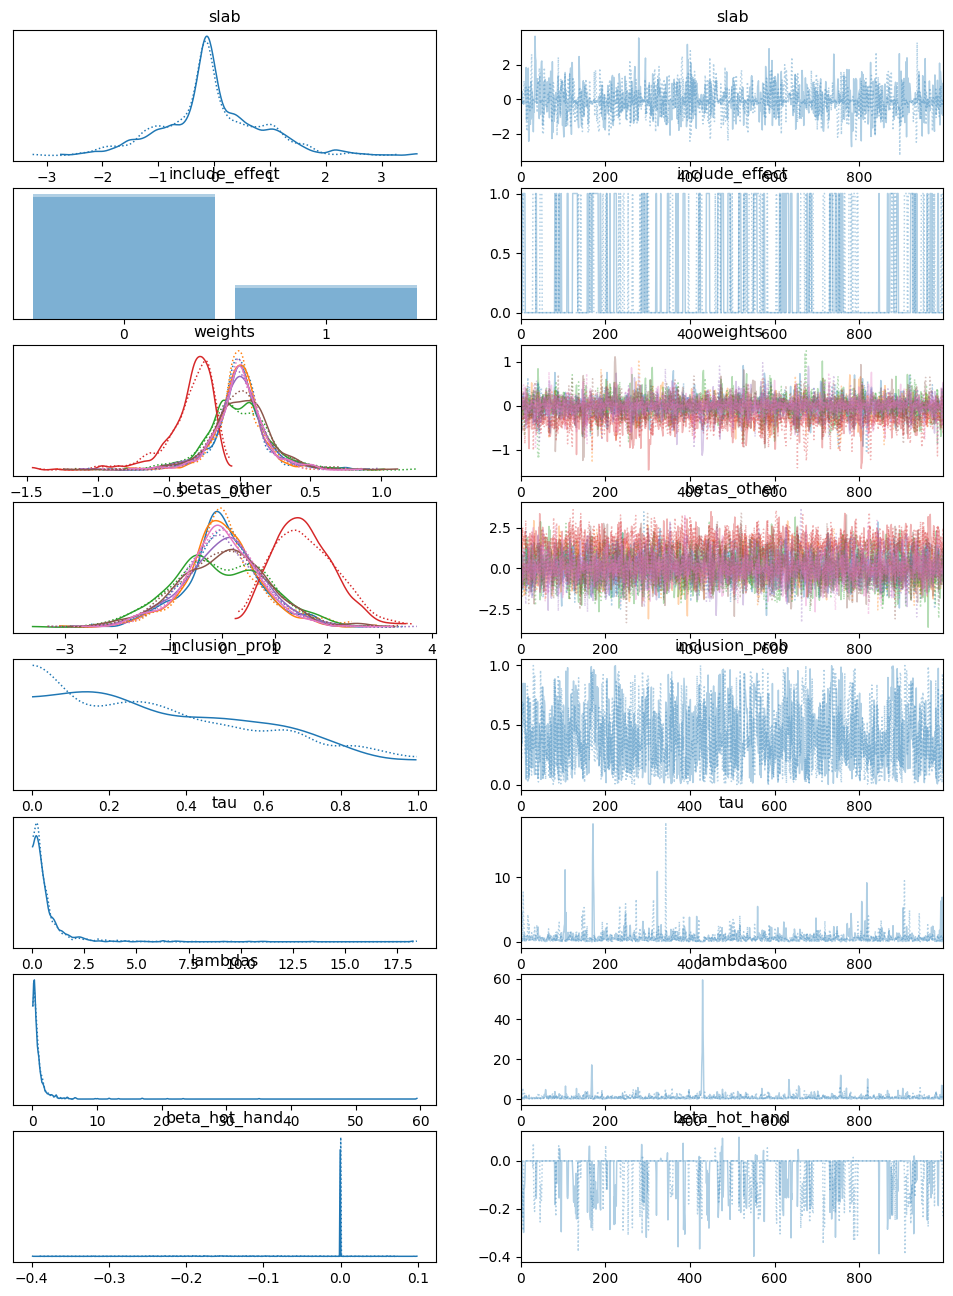

In [ ]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata);
print("HMC Split-Rhats", {k: np.round(v.values,P2+1) for k,v in az.rhat(idata).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.

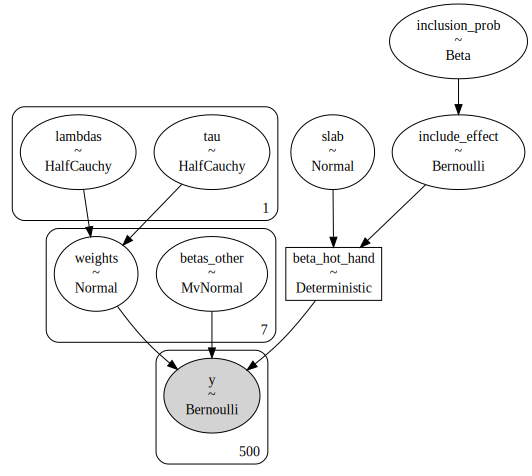

In [ ]:
# Visualization of model graph
pm.model_to_graphviz(model)

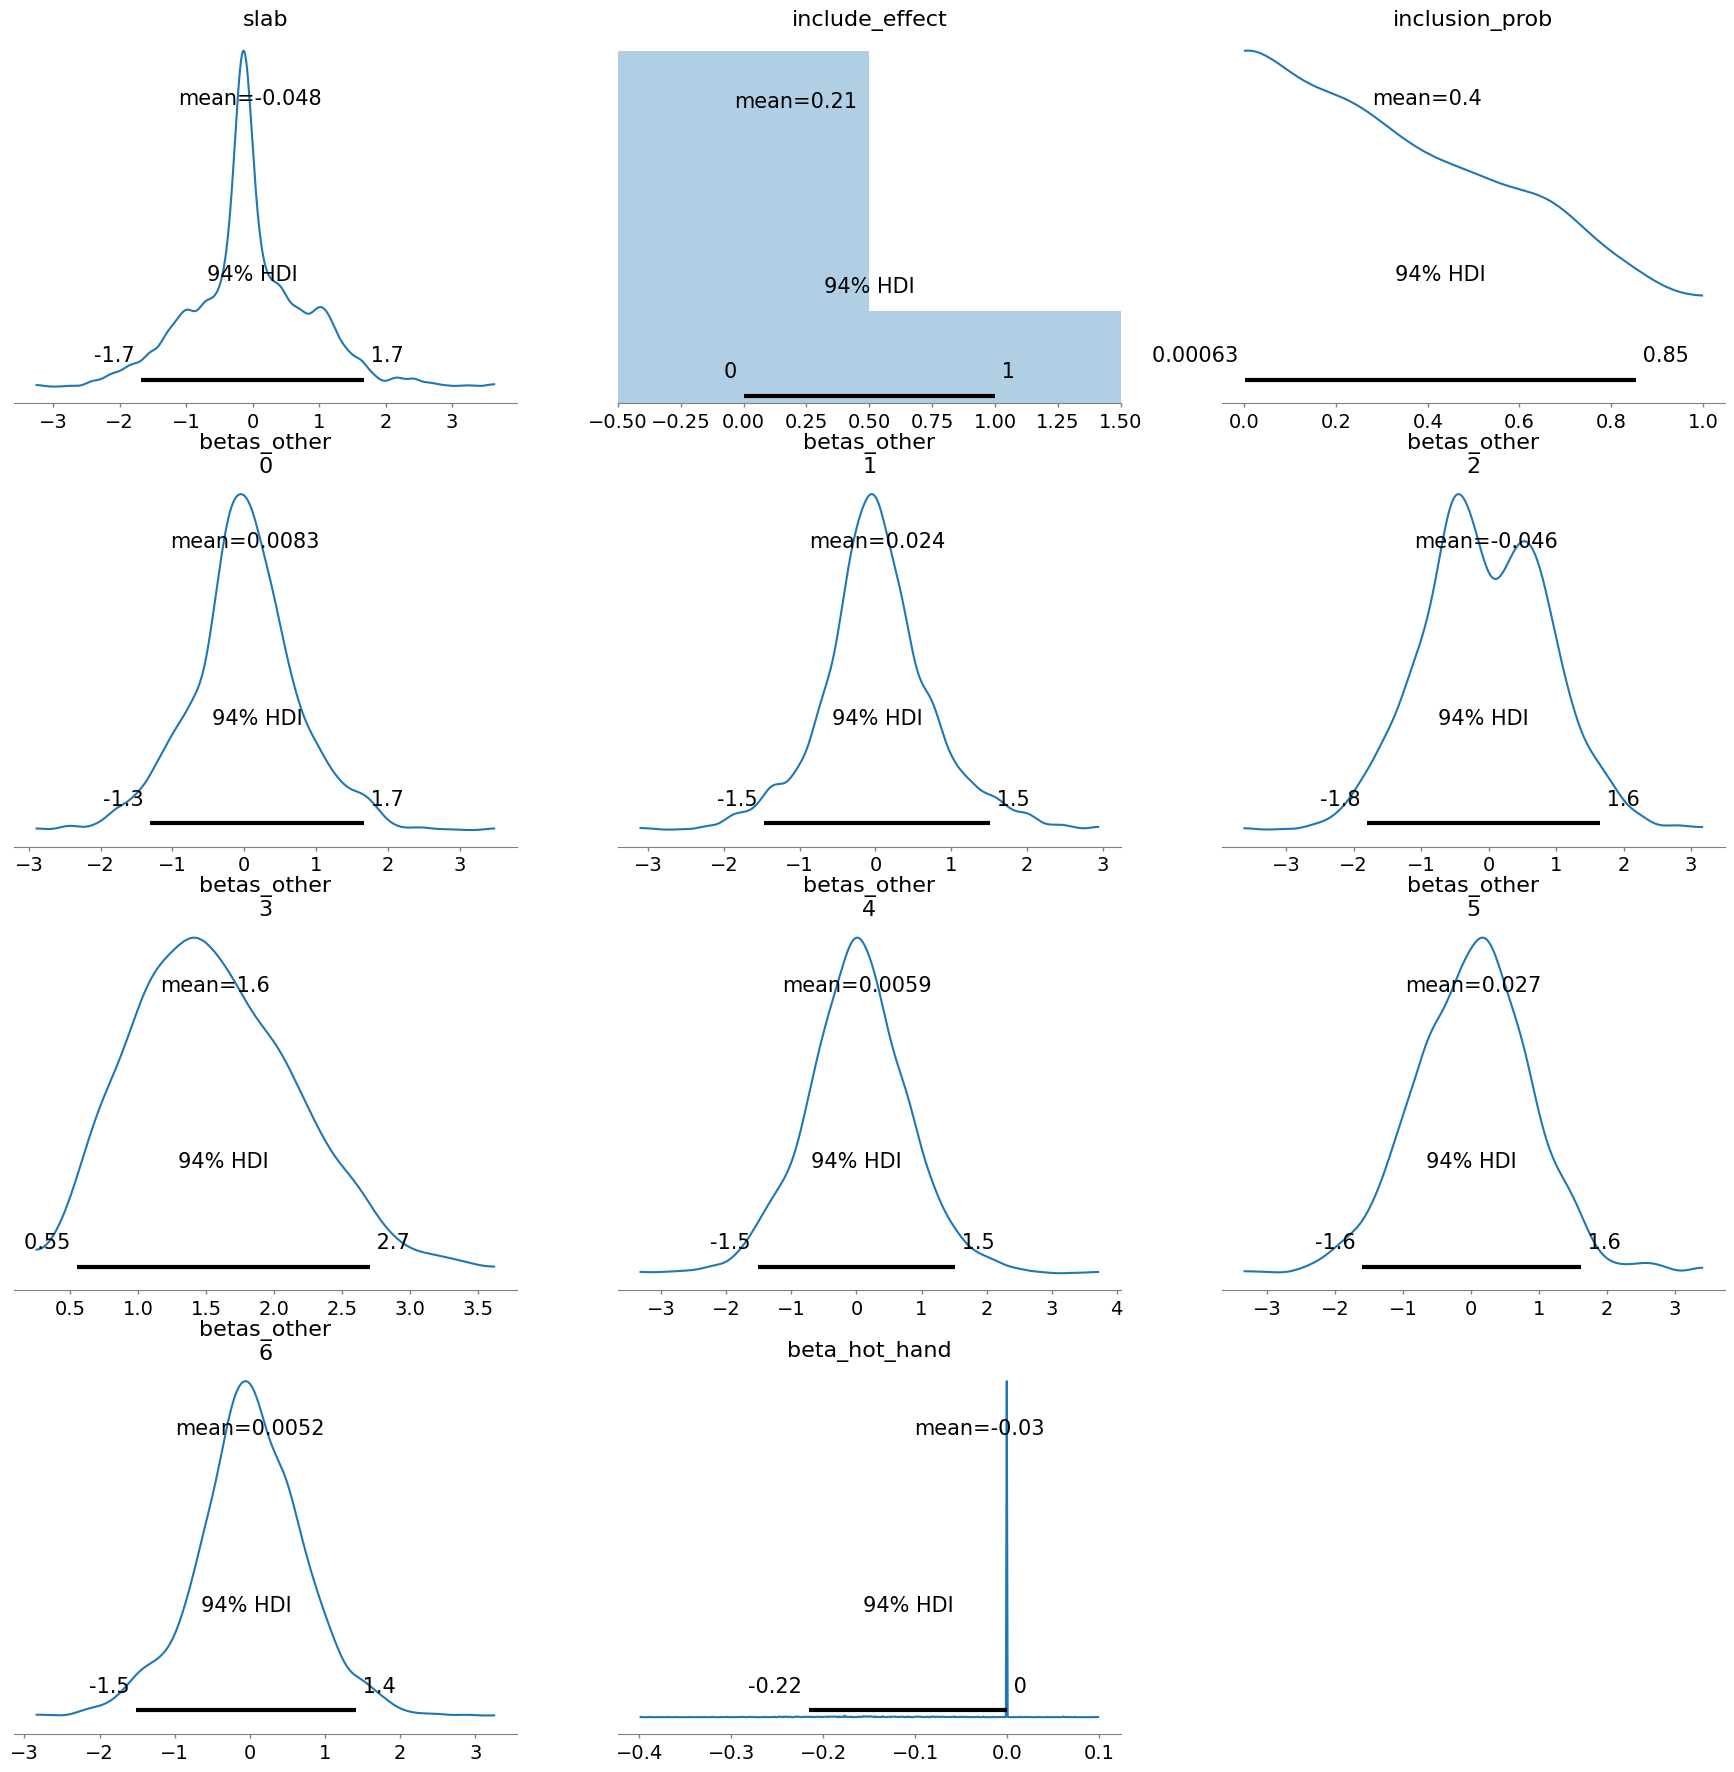

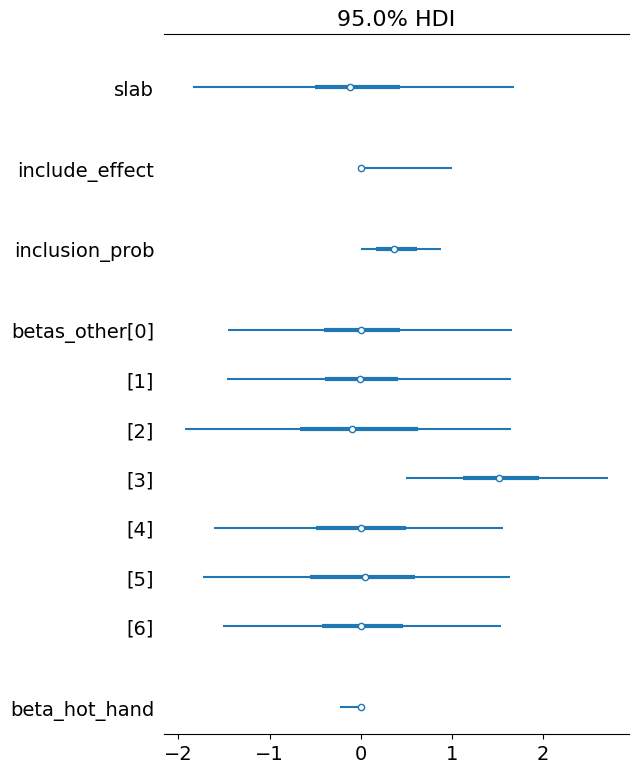

In [ ]:
# Posterior plots
az.plot_posterior(idata, var_names=['slab', 'include_effect', 'inclusion_prob','betas_other', 'beta_hot_hand'])
plt.show()

# Forest plots
az.plot_forest(idata, var_names=['slab', 'include_effect', 'inclusion_prob', 'betas_other', 'beta_hot_hand'], combined=True, hdi_prob=0.95)
plt.show()
